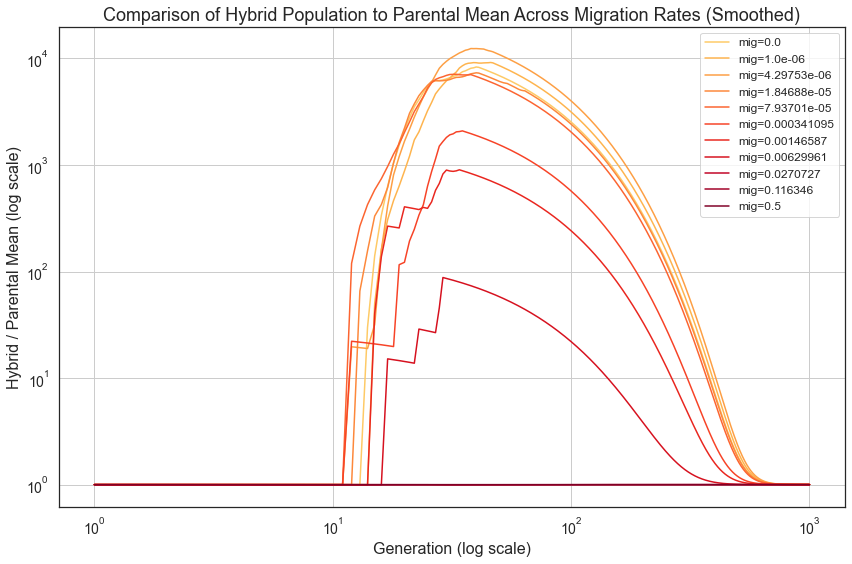

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
import warnings

# Template for file path
file_path_template = "~/Desktop/Data/FGM_experiment_mig={}_run={}_p{}.dat"

# Reference point for Euclidean distance calculation
reference_point = np.array([4, 0, 0, 0])

# Numerically solve 1 − P = exp(−w*5*P) for P
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Ignore warnings

def solve_p(w):
    def equation(p):
        return 1 - p - np.exp(-w * 5 * p)
    try:
        p_solution = fsolve(equation, 0.5)  # Solve with initial guess of 0.5
        return p_solution[0]
    except Exception:
        return 1e-6  # Return minimum value if no solution is found

# Calculate Euclidean distance
def calculate_euclidean_distance(row, reference):
    phenotype = np.array([row['phenotype1'], row['phenotype2'], row['phenotype3'], row['phenotype4']])
    return np.linalg.norm(phenotype - reference)

# Store results for each migration value
mig_values = [
    "0.0", "1.0e-06", "4.29753e-06", "1.84688e-05", "7.93701e-05", "0.000341095", "0.00146587", "0.00629961", "0.0270727", "0.116346", "0.5"
]
mean_comparisons_by_mig = {}

# Loop over migration values
for mig in mig_values:
    all_comparisons = []
    
    # Loop over runs
    for run in range(100):
        # Generate file paths
        file1_path = file_path_template.format(mig, run, 1)
        file2_path = file_path_template.format(mig, run, 2)

        # Load files
        data1 = pd.read_csv(file1_path, delim_whitespace=True, header=None)
        data2 = pd.read_csv(file2_path, delim_whitespace=True, header=None)

        # Set headers
        data1.columns = data1.iloc[0]
        data2.columns = data2.iloc[0]
        data1 = data1[1:]
        data2 = data2[1:]

        # Convert necessary columns to numeric type
        for col in ['phenotype1', 'phenotype2', 'phenotype3', 'phenotype4', 'generation']:
            data1[col] = pd.to_numeric(data1[col], errors='coerce')
            data2[col] = pd.to_numeric(data2[col], errors='coerce')

        # Compute hybrid population
        data3 = pd.DataFrame()
        data3['phenotype1'] = (data1['phenotype1'] + data2['phenotype1']) / 2
        data3['phenotype2'] = (data1['phenotype2'] + data2['phenotype2']) / 2
        data3['phenotype3'] = (data1['phenotype3'] + data2['phenotype3']) / 2
        data3['phenotype4'] = (data1['phenotype4'] + data2['phenotype4']) / 2
        data3['generation'] = data1['generation']

        # Calculate distances
        data1['distance'] = data1.apply(lambda row: calculate_euclidean_distance(row, reference_point), axis=1)
        data2['distance'] = data2.apply(lambda row: calculate_euclidean_distance(row, reference_point), axis=1)
        data3['distance'] = data3.apply(lambda row: calculate_euclidean_distance(row, reference_point), axis=1)

        # Compute exp(-4 * distance^2)
        data1['exp_distance'] = np.exp(-4 * data1['distance']**2)
        data2['exp_distance'] = np.exp(-4 * data2['distance']**2)
        data3['exp_distance'] = np.exp(-4 * data3['distance']**2)

        # Compute P for each population
        data1['P'] = data1['exp_distance'].apply(solve_p).clip(lower=1e-6)
        data2['P'] = data2['exp_distance'].apply(solve_p).clip(lower=1e-6)
        data3['P'] = data3['exp_distance'].apply(solve_p).clip(lower=1e-6)

        # Compute parental mean
        data_parental_mean = pd.DataFrame()
        data_parental_mean['generation'] = data1['generation']
        data_parental_mean['P'] = ((data1['P'] + data2['P']) / 2).clip(lower=1e-6)

        # Compute ratio of hybrid population to parental mean
        data_comparison = pd.DataFrame()
        data_comparison['generation'] = data3['generation']
        data_comparison['ratio'] = data3['P'] / data_parental_mean['P']

        all_comparisons.append(data_comparison)

    # Concatenate all results
    all_comparisons = pd.concat(all_comparisons)

    # Compute mean ratio for each generation
    mean_comparisons = all_comparisons.groupby('generation')['ratio'].mean().reset_index()

    # Smoothing: exponential moving average
    mean_comparisons['smoothed_ratio'] = mean_comparisons['ratio'].ewm(span=100, adjust=False).mean()

    mean_comparisons_by_mig[mig] = mean_comparisons

# Plot saving settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Generate color gradient (yellow to red)
num_mig = len(mean_comparisons_by_mig)  # Number of migration values
colors = plt.cm.YlOrRd(np.linspace(0.3, 1, num_mig))  # Create gradient (yellow to red)

# Plot
plt.figure(figsize=(12, 8))
for idx, (mig, comparisons) in enumerate(mean_comparisons_by_mig.items()):
    plt.plot(
        comparisons['generation'], comparisons['smoothed_ratio'],
        linestyle='-', color=colors[idx], label=f'mig={mig}'
    )

# Set axis scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Generation (log scale)', fontsize=16)  # Increase label font size
plt.ylabel('Hybrid / Parental Mean (log scale)', fontsize=16)
plt.title('Comparison of Hybrid Population to Parental Mean Across Migration Rates (Smoothed)', fontsize=18)

# Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

# Add legend
plt.legend(fontsize=12)

# Enable grid
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Save as PDF
plt.savefig("Hybrid_Parental_Mean_Comparison.pdf", format='pdf')
plt.show()

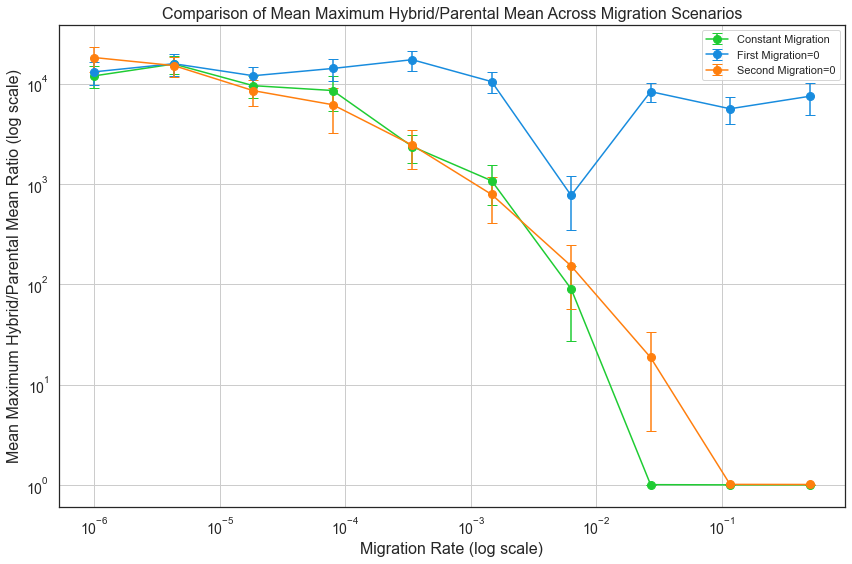

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
import warnings

# Template for file paths
file1_path_template = "~/Desktop/Data/FGM_experiment_firstmig=0_mig={}_run={}_p{}.dat"
file2_path_template = "~/Desktop/Data/FGM_experiment_secondmig=0_mig={}_run={}_p{}.dat"
file3_path_template = "~/Desktop/Data/FGM_experiment_mig={}_run={}_p{}.dat"

# Numerically solve 1 − P = exp(−w*5*P) for P
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Ignore warnings

def solve_p(w):
    def equation(p):
        return 1 - p - np.exp(-w * 5 * p)
    try:
        p_solution = fsolve(equation, 0.5)  # Solve with an initial guess of 0.5
        return p_solution[0]
    except Exception:
        return 1e-6  # Return minimum value if no solution is found

# Calculate Euclidean distance
def calculate_euclidean_distance(row, reference):
    phenotype = np.array([row['phenotype1'], row['phenotype2'], row['phenotype3'], row['phenotype4']])
    return np.linalg.norm(phenotype - reference)

# Function to process data
def process_data(file_template, mig_values, scenario_name):
    max_values_by_mig = {}
    
    for mig in mig_values:
        max_values = []  # List to hold maximum values for each run
        
        for run in range(100):
            # Generate file paths
            file_path_p1 = file_template.format(mig, run, 1)
            file_path_p2 = file_template.format(mig, run, 2)

            # Load files
            data_p1 = pd.read_csv(file_path_p1, delim_whitespace=True, header=None)
            data_p2 = pd.read_csv(file_path_p2, delim_whitespace=True, header=None)

            # Set headers
            data_p1.columns = data_p1.iloc[0]
            data_p2.columns = data_p2.iloc[0]
            data_p1 = data_p1[1:]
            data_p2 = data_p2[1:]

            # Convert necessary columns to numeric type
            for col in ['phenotype1', 'phenotype2', 'phenotype3', 'phenotype4', 'generation']:
                data_p1[col] = pd.to_numeric(data_p1[col], errors='coerce')
                data_p2[col] = pd.to_numeric(data_p2[col], errors='coerce')

            # Compute hybrid population
            hybrid_data = pd.DataFrame()
            hybrid_data['phenotype1'] = (data_p1['phenotype1'] + data_p2['phenotype1']) / 2
            hybrid_data['phenotype2'] = (data_p1['phenotype2'] + data_p2['phenotype2']) / 2
            hybrid_data['phenotype3'] = (data_p1['phenotype3'] + data_p2['phenotype3']) / 2
            hybrid_data['phenotype4'] = (data_p1['phenotype4'] + data_p2['phenotype4']) / 2
            hybrid_data['generation'] = data_p1['generation']

            # Calculate distances
            data_p1['distance'] = data_p1.apply(lambda row: calculate_euclidean_distance(row, [4, 0, 0, 0]), axis=1)
            data_p2['distance'] = data_p2.apply(lambda row: calculate_euclidean_distance(row, [4, 0, 0, 0]), axis=1)
            hybrid_data['distance'] = hybrid_data.apply(lambda row: calculate_euclidean_distance(row, [4, 0, 0, 0]), axis=1)

            # Compute exp(-4 * distance^2)
            data_p1['exp_distance'] = np.exp(-4 * data_p1['distance']**2)
            data_p2['exp_distance'] = np.exp(-4 * data_p2['distance']**2)
            hybrid_data['exp_distance'] = np.exp(-4 * hybrid_data['distance']**2)

            # Compute P for each population
            data_p1['P'] = data_p1['exp_distance'].apply(solve_p).clip(lower=1e-6)
            data_p2['P'] = data_p2['exp_distance'].apply(solve_p).clip(lower=1e-6)
            hybrid_data['P'] = hybrid_data['exp_distance'].apply(solve_p).clip(lower=1e-6)

            # Compute parental mean
            data_parental_mean = pd.DataFrame()
            data_parental_mean['generation'] = data_p1['generation']
            data_parental_mean['P'] = ((data_p1['P'] + data_p2['P']) / 2).clip(lower=1e-6)

            # Compute ratio of hybrid population to parental mean
            data_comparison = pd.DataFrame()
            data_comparison['generation'] = hybrid_data['generation']
            data_comparison['ratio'] = hybrid_data['P'] / data_parental_mean['P']

            # Compute mean ratio for each generation
            mean_comparisons = data_comparison.groupby('generation')['ratio'].mean().reset_index()

            # Smoothing: exponential moving average
            mean_comparisons['smoothed_ratio'] = mean_comparisons['ratio'].ewm(span=100, adjust=False).mean()

            # Obtain maximum of the mean time series
            max_value = mean_comparisons['smoothed_ratio'].max()
            max_values.append(max_value)

        max_values_by_mig[mig] = max_values

    # Calculate mean and standard error
    summary = []
    for mig, max_values in max_values_by_mig.items():
        mean_max = np.mean(max_values)
        se_max = np.std(max_values) / np.sqrt(len(max_values))
        summary.append((float(mig), mean_max, se_max))

    summary_df = pd.DataFrame(summary, columns=['migration_rate', 'mean_max', 'se_max'])
    summary_df['scenario'] = scenario_name

    return summary_df

# Mig values
mig_values = [
    "1.0e-06", "4.29753e-06", "1.84688e-05", "7.93701e-05", "0.000341095", "0.00146587", "0.00629961", "0.0270727", "0.116346", "0.5"
]

# Process each scenario
summary_first = process_data(file1_path_template, mig_values, 'First Migration=0')
summary_second = process_data(file2_path_template, mig_values, 'Second Migration=0')
summary_constant = process_data(file3_path_template, mig_values, 'Constant Migration')

# Combine all data
total_summary = pd.concat([summary_first, summary_second, summary_constant])

# Plot saving settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot
plt.figure(figsize=(12, 8))
colors = {'First Migration=0': '#188cde', 'Second Migration=0': '#ff7f0e', 'Constant Migration': '#1fcc33'}
for scenario, group_data in total_summary.groupby('scenario'):
    plt.errorbar(
        group_data['migration_rate'], group_data['mean_max'],
        yerr=group_data['se_max'], fmt='o-', label=scenario, color=colors[scenario], markersize=8, capsize=5
    )

# Set axis scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Migration Rate (log scale)', fontsize=16)
plt.ylabel('Mean Maximum Hybrid/Parental Mean Ratio (log scale)', fontsize=16)
plt.title('Comparison of Mean Maximum Hybrid/Parental Mean Across Migration Scenarios', fontsize=16)
plt.legend()

# Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.grid(True)
plt.tight_layout()

# Save as PDF
plt.savefig("Hybrid_Parental_Mean_Comparison_mig.pdf", format='pdf')

plt.show()

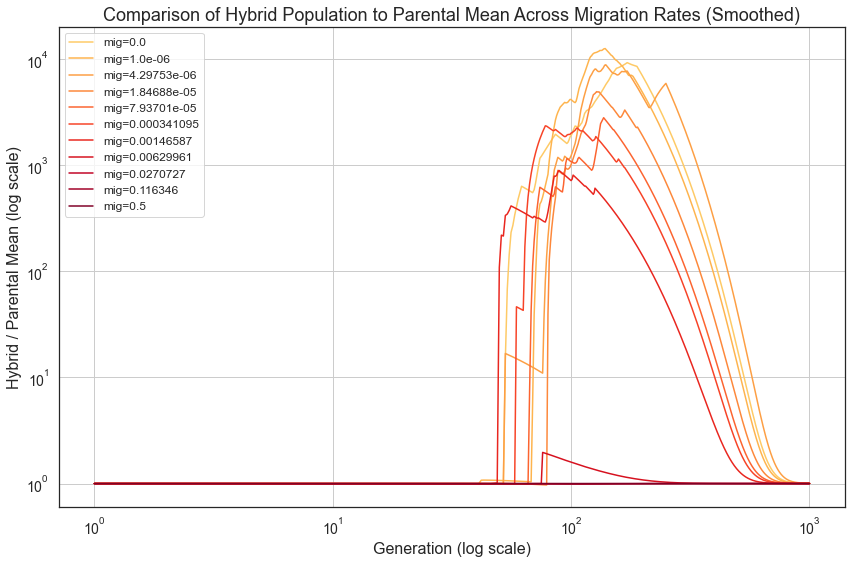

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
import warnings

# Template for file path
file_path_template = "~/Desktop/SLiM_pop/FGM_experiment_mig={}_g=1.2_run={}_p{}.dat"

# Reference point for Euclidean distance calculation
reference_point = np.array([4, 0, 0, 0])

# Numerically solve 1 − P = exp(−w*5*P) for P
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Ignore warnings

def solve_p(w):
    def equation(p):
        return 1 - p - np.exp(-w * 5 * p)
    try:
        p_solution = fsolve(equation, 0.5)  # Solve with initial guess of 0.5
        return p_solution[0]
    except Exception:
        return 1e-6  # Return minimum value if no solution is found

# Calculate Euclidean distance
def calculate_euclidean_distance(row, reference):
    phenotype = np.array([row['phenotype1'], row['phenotype2'], row['phenotype3'], row['phenotype4']])
    return np.linalg.norm(phenotype - reference)

# Store results for each migration value
mig_values = [
    "0.0", "1.0e-06", "4.29753e-06", "1.84688e-05", "7.93701e-05",
    "0.000341095", "0.00146587", "0.00629961", "0.0270727", "0.116346", "0.5"
]
mean_comparisons_by_mig = {}

# Loop over migration values
for mig in mig_values:
    all_comparisons = []
    
    # Loop over runs
    for run in range(100):
        # Generate file path
        file1_path = file_path_template.format(mig, run, 1)
        file2_path = file_path_template.format(mig, run, 2)

        # Load files
        data1 = pd.read_csv(file1_path, delim_whitespace=True, header=None)
        data2 = pd.read_csv(file2_path, delim_whitespace=True, header=None)

        # Set headers
        data1.columns = data1.iloc[0]
        data2.columns = data2.iloc[0]
        data1 = data1[1:]
        data2 = data2[1:]

        # Convert necessary columns to numeric type
        for col in ['phenotype1', 'phenotype2', 'phenotype3', 'phenotype4', 'generation']:
            data1[col] = pd.to_numeric(data1[col], errors='coerce')
            data2[col] = pd.to_numeric(data2[col], errors='coerce')

        # Compute hybrid population
        data3 = pd.DataFrame()
        data3['phenotype1'] = (data1['phenotype1'] + data2['phenotype1']) / 2
        data3['phenotype2'] = (data1['phenotype2'] + data2['phenotype2']) / 2
        data3['phenotype3'] = (data1['phenotype3'] + data2['phenotype3']) / 2
        data3['phenotype4'] = (data1['phenotype4'] + data2['phenotype4']) / 2
        data3['generation'] = data1['generation']

        # Calculate distances
        data1['distance'] = data1.apply(lambda row: calculate_euclidean_distance(row, reference_point), axis=1)
        data2['distance'] = data2.apply(lambda row: calculate_euclidean_distance(row, reference_point), axis=1)
        data3['distance'] = data3.apply(lambda row: calculate_euclidean_distance(row, reference_point), axis=1)

        # Compute exp(-4 * distance^2)
        data1['exp_distance'] = np.exp(-4 * data1['distance']**2)
        data2['exp_distance'] = np.exp(-4 * data2['distance']**2)
        data3['exp_distance'] = np.exp(-4 * data3['distance']**2)

        # Compute P for each population
        data1['P'] = data1['exp_distance'].apply(solve_p).clip(lower=1e-6)
        data2['P'] = data2['exp_distance'].apply(solve_p).clip(lower=1e-6)
        data3['P'] = data3['exp_distance'].apply(solve_p).clip(lower=1e-6)

        # Compute parental mean
        data_parental_mean = pd.DataFrame()
        data_parental_mean['generation'] = data1['generation']
        data_parental_mean['P'] = ((data1['P'] + data2['P']) / 2).clip(lower=1e-6)

        # Compute ratio of hybrid population to parental mean
        data_comparison = pd.DataFrame()
        data_comparison['generation'] = data3['generation']
        data_comparison['ratio'] = data3['P'] / data_parental_mean['P']

        all_comparisons.append(data_comparison)

    # Concatenate all results
    all_comparisons = pd.concat(all_comparisons)

    # Compute mean ratio for each generation
    mean_comparisons = all_comparisons.groupby('generation')['ratio'].mean().reset_index()

    # Smoothing: exponential moving average
    mean_comparisons['smoothed_ratio'] = mean_comparisons['ratio'].ewm(span=100, adjust=False).mean()

    mean_comparisons_by_mig[mig] = mean_comparisons

# Plot saving settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Generate color gradient (yellow to red)
num_mig = len(mean_comparisons_by_mig)  # Number of migration values
colors = plt.cm.YlOrRd(np.linspace(0.3, 1, num_mig))  # Create gradient (yellow to red)

# Plot
plt.figure(figsize=(12, 8))
for idx, (mig, comparisons) in enumerate(mean_comparisons_by_mig.items()):
    plt.plot(
        comparisons['generation'], comparisons['smoothed_ratio'],
        linestyle='-', color=colors[idx], label=f'mig={mig}'
    )

# Set axis scales
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel('Generation (log scale)', fontsize=16)  # Increase label font size
plt.ylabel('Hybrid / Parental Mean (log scale)', fontsize=16)
plt.title('Comparison of Hybrid Population to Parental Mean Across Migration Rates (Smoothed)', fontsize=18)

# Increase tick label size
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)

# Add legend
plt.legend(fontsize=12)

# Set grid off
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Save as PDF
plt.savefig("Hybrid_Parental_Mean_Comparison_pop.pdf", format='pdf')
plt.show()